In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Functions
# Add the directory containing the module to sys.path
sys.path.append(os.path.abspath('functions'))
from preprocessing import read_csv_files, check_missing_values, forward_fill, backward_fill, linear_interpolation, calculate_volatility, adf_test, map_date_range, create_volatility_df
from spillover import calculate_avg_spillover_table, calculate_net_pairwise_spillover_table

## Data Preprocessing

In [2]:
# Retrieve a list of DataFrames
dataframes = read_csv_files("data")

In [3]:
# Convert each column in every DataFrame to lowercase
for key in dataframes:
    dataframes[key].columns = map(str.lower, dataframes[key].columns)

Converting the `date` column to datetime object, this process has to be handled individually since each DataFrame has a different date format. We cannot let Pandas infers the date format for each DataFrame since it can be prone to infer the wrong format. Below are the format of each DataFrame:
- Philippines: MM/DD/YYYY
- Singapore: MM/DD/YYYY
- India: YYYY-MM-DD
- United Kingdom: DD/MM/YYYY
- Mexico: YYYY-MM-DD
- Japan: YYYY-MM-DD
- Vietnam: DD/MM/YYYY
- Korea: YYYY-MM-DD
- Thailand: YYYY-MM-DD
- Brazil: YYYY-MM-DD
- Malaysia: DD/MM/YYYY
- Switzerland: YYYY-MM-DD
- China: DD/MM/YYYY
- Russia: YYYY-MM-DD
- United States: YYYY-MM-DD

In [4]:
date_format_mapping = {
  'philippines': '%m/%d/%Y',
  'singapore': '%m/%d/%Y',
  'india': '%Y-%m-%d',
  'uk': '%d/%m/%Y',
  'mexico': '%Y-%m-%d',
  'japan': '%Y-%m-%d',
  'vietnam': '%d/%m/%Y',
  'korea': '%Y-%m-%d',
  'thailand': '%Y-%m-%d',
  'brazil': '%Y-%m-%d',
  'malaysia': '%d/%m/%Y',
  'switzerland': '%Y-%m-%d',
  'china': '%d/%m/%Y',
  'russia': '%Y-%m-%d',
  'us': '%Y-%m-%d',
}

# Convert the date columns to datetime objects
for key in dataframes:
    try:
      dataframes[key]['date'] = pd.to_datetime(
        dataframes[key]['date'], 
        format=date_format_mapping[key]
      )
    except Exception as e:
      print(f"Error occurred for country: {key}")
      print(f"Error message: {str(e)}")

In [5]:
# Sort the dataframes by date in ascending order
for key in dataframes:
    dataframes[key] = dataframes[key].sort_values(by='date')

In [6]:
# Reset the index of the dataframes
for key in dataframes:
    dataframes[key] = dataframes[key].reset_index(drop=True)

In [7]:
# Extract only open, high, low, close columns
for key in dataframes:
    dataframes[key] = dataframes[key][['date', 'open', 'high', 'low', 'close']]

In [8]:
for df in dataframes.values():
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597 entries, 0 to 5596
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5597 non-null   datetime64[ns]
 1   open    5597 non-null   object        
 2   high    5597 non-null   object        
 3   low     5597 non-null   object        
 4   close   5597 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 218.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656 entries, 0 to 5655
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5656 non-null   datetime64[ns]
 1   open    5607 non-null   float64       
 2   high    5607 non-null   float64       
 3   low     5607 non-null   float64       
 4   close   5607 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 221.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Ra

Since the columns open, high, low, close have different dtypes (`float64` and `object`) for different DataFrame, they should be converted to `float64`.

In [9]:
# Convert open, high, low, close columns to float
for key in dataframes:
  for col in ['open', 'high', 'low', 'close']:
    if dataframes[key][col].dtype == 'object':
      dataframes[key][col] = dataframes[key][col].str.replace(',', '').astype(float)


In [10]:
# Check whether the columns have been converted to float
for df in dataframes.values():
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597 entries, 0 to 5596
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5597 non-null   datetime64[ns]
 1   open    5597 non-null   float64       
 2   high    5597 non-null   float64       
 3   low     5597 non-null   float64       
 4   close   5597 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 218.8 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656 entries, 0 to 5655
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5656 non-null   datetime64[ns]
 1   open    5607 non-null   float64       
 2   high    5607 non-null   float64       
 3   low     5607 non-null   float64       
 4   close   5607 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 221.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Ra

##### Data imputation

In [11]:
check_missing_values(dataframes)

Missing values for uk:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for mexico:
date      0
open     49
high     49
low      49
close    49
dtype: int64


Missing values for japan:
date      0
open     93
high     93
low      93
close    93
dtype: int64


Missing values for korea:
date      0
open     66
high     66
low      66
close    66
dtype: int64


Missing values for thailand:
date      0
open     73
high     73
low      73
close    73
dtype: int64


Missing values for switzerland:
date      0
open     52
high     52
low      52
close    52
dtype: int64


Missing values for us:
date     0
open     0
high     0
low      0
close    0
dtype: int64




In [12]:
# Impute missing values in the dataframes using linear interpolation method
dataframes = linear_interpolation(dataframes)

In [13]:
# Check whether the missing values have been imputed
check_missing_values(dataframes)

Missing values for uk:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for mexico:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for japan:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for korea:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for thailand:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for switzerland:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for us:
date     0
open     0
high     0
low      0
close    0
dtype: int64




##### Timeframe normalisation

In [14]:
# Map the dataframes to a new date range that includes all the business days from 2002-01-02 to 2024-04-30
dataframes = map_date_range(dataframes, '2002-01-02', '2024-04-30')

In [15]:
# Check for missing values after mapping the dataframes to a new date range
check_missing_values(dataframes)

Missing values for uk:
date       0
open     228
high     228
low      228
close    228
dtype: int64


Missing values for mexico:
date       0
open     169
high     169
low      169
close    169
dtype: int64


Missing values for japan:
date       0
open     266
high     266
low      266
close    266
dtype: int64


Missing values for korea:
date       0
open     247
high     247
low      247
close    247
dtype: int64


Missing values for thailand:
date       0
open     310
high     310
low      310
close    310
dtype: int64


Missing values for switzerland:
date       0
open     163
high     163
low      163
close    163
dtype: int64


Missing values for us:
date       0
open     205
high     205
low      205
close    205
dtype: int64




In [16]:
# Perform forward filling on the dataframes
dataframes = forward_fill(dataframes)

/Users/annguyen/Documents/Master Degree/Dissertation/Submissions/Experiments/functions/preprocessing.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


In [17]:
# Check for missing values after performing forward filling
check_missing_values(dataframes)

Missing values for uk:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for mexico:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for japan:
date     0
open     2
high     2
low      2
close    2
dtype: int64


Missing values for korea:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for thailand:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for switzerland:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for us:
date     0
open     0
high     0
low      0
close    0
dtype: int64




In [18]:
# Perform backward filling on the dataframes to handle any remaining missing values
dataframes = backward_fill(dataframes)

/Users/annguyen/Documents/Master Degree/Dissertation/Submissions/Experiments/functions/preprocessing.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


##### Volatility calculation

In [19]:
# Calculate the volatility for each country
dataframes = calculate_volatility(dataframes)

In [20]:
# Create volatility Dataframe
volatility_df = create_volatility_df(dataframes)

# Save the volatility DataFrame to a CSV file
volatility_df.to_csv('output/volatility.csv', index=False)

# Reset the date column to index
volatility_df = volatility_df.set_index('date')

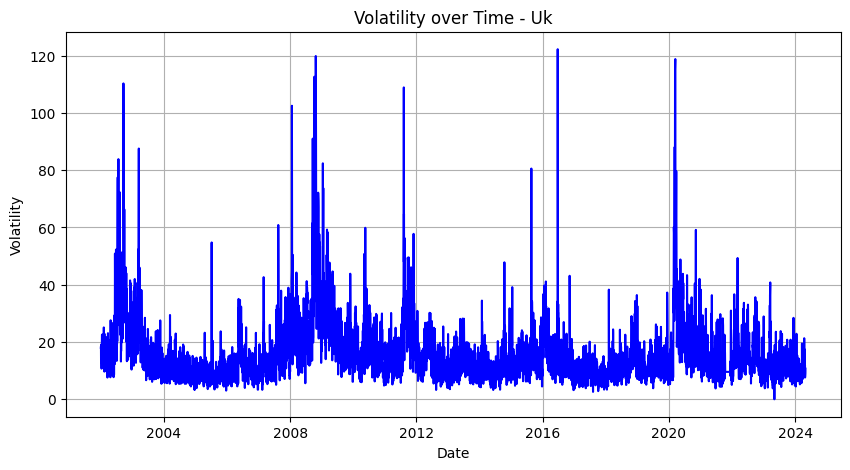

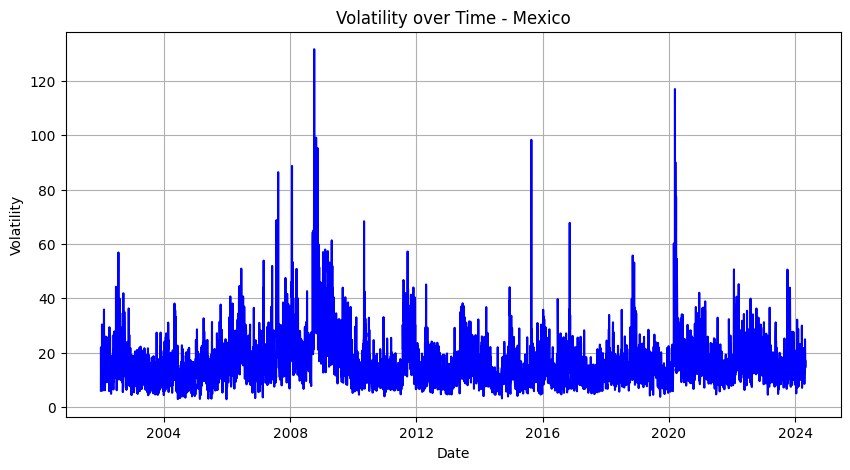

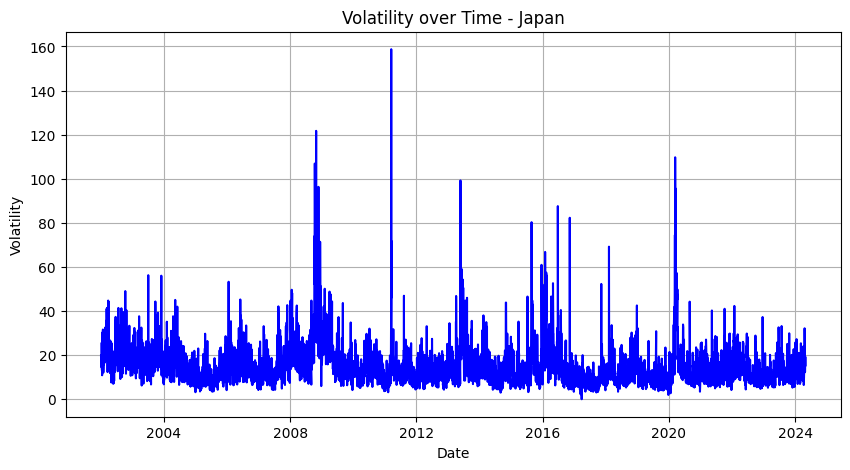

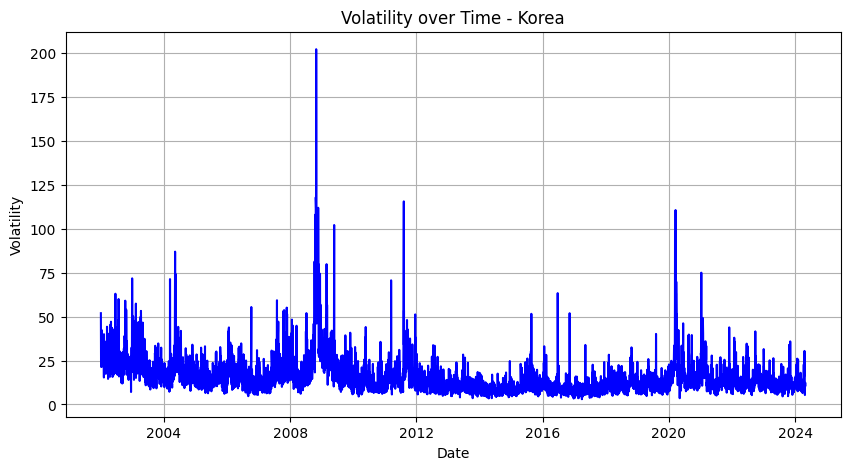

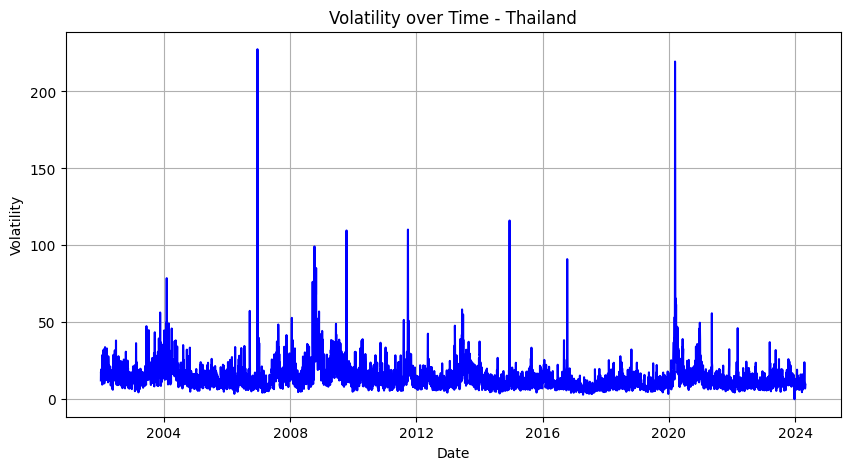

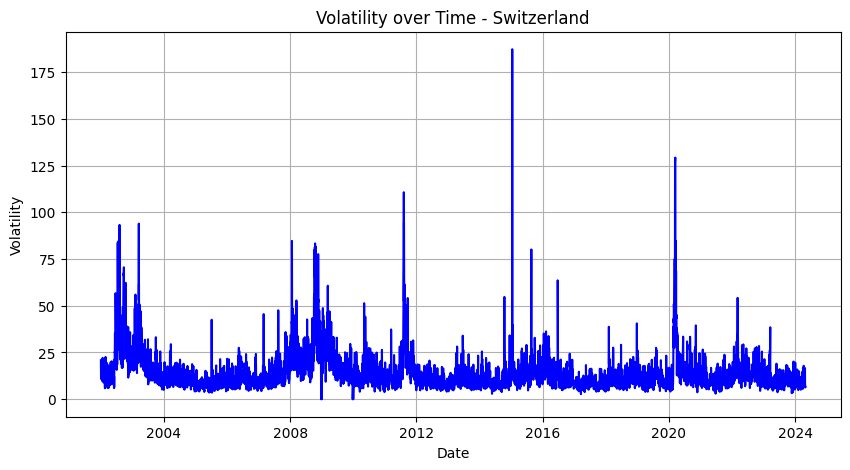

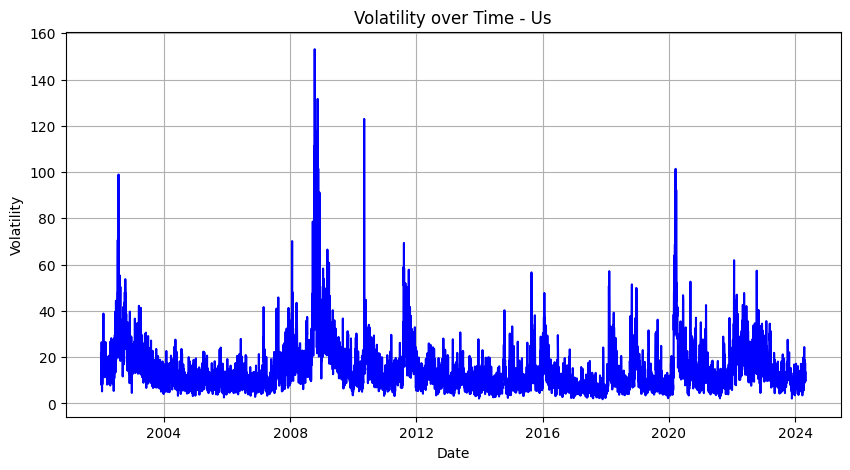

In [21]:
# Visualize the volatility of each country
for column in volatility_df.columns:
  plt.figure(figsize=(10, 5))
  plt.plot(volatility_df.index, volatility_df[column], label=column, color='blue')
  plt.title(f'Volatility over Time - {column.capitalize()}')
  plt.xlabel('Date')
  plt.ylabel('Volatility')
  plt.grid(True)
  plt.savefig(f'output/plots/volatility_{column.upper()}.png')  # Save the plot
  plt.show()


##### Augmented Dickey-Fuller (ADF) test

In [22]:
for country in volatility_df.columns:
  adf_test(volatility_df, country)

Results of Augmented Dickey-Fuller Test for uk:
ADF Statistic: -6.240839580494232
p-value: 4.701620665518484e-08
Critical Values:
	1%: -3.431478938567795
	5%: -2.8620388838347126
	10%: -2.567035553878898
Reject the null hypothesis. The time series uk is stationary.


Results of Augmented Dickey-Fuller Test for mexico:
ADF Statistic: -6.7110582149695945
p-value: 3.679790469568243e-09
Critical Values:
	1%: -3.4314799139042953
	5%: -2.862039314759095
	10%: -2.5670357832723325
Reject the null hypothesis. The time series mexico is stationary.


Results of Augmented Dickey-Fuller Test for japan:
ADF Statistic: -8.297506928092286
p-value: 4.1021193335394816e-13
Critical Values:
	1%: -3.4314777703843267
	5%: -2.8620383677062575
	10%: -2.567035279128919
Reject the null hypothesis. The time series japan is stationary.


Results of Augmented Dickey-Fuller Test for korea:
ADF Statistic: -7.706244778847388
p-value: 1.2993121296025538e-11
Critical Values:
	1%: -3.4314775759220844
	5%: -2.86203828178

All of the variables are stationary. Therefore, no transformation is needed.

## VAR Modelling

In [23]:
window_1_start = '2002-01-02'
window_1_end = '2007-09-17'

window_2_start = '2007-09-18'
window_2_end = '2011-10-27'

window_3_start = '2011-10-28'
window_3_end = '2018-12-31'

window_4_start = '2019-01-02'
window_4_end = '2022-12-31'

window_5_start = '2023-01-02'
window_5_end = '2024-04-30'

df_window_1 = volatility_df.loc[(volatility_df.index >= window_1_start) & (volatility_df.index <= window_1_end)]
df_window_2 = volatility_df.loc[(volatility_df.index >= window_2_start) & (volatility_df.index <= window_2_end)]
df_window_3 = volatility_df.loc[(volatility_df.index >= window_3_start) & (volatility_df.index <= window_3_end)]
df_window_4 = volatility_df.loc[(volatility_df.index >= window_4_start) & (volatility_df.index <= window_4_end)]
df_window_5 = volatility_df.loc[(volatility_df.index >= window_5_start) & (volatility_df.index <= window_5_end)]

windowed_vol_dfs = [df_window_1, df_window_2, df_window_3, df_window_4, df_window_5]

for i, df_volatility in enumerate(windowed_vol_dfs):
  window = f"window_{i+1}"
  print(f"Calculating spillover for {window}...")
  # Calculate the average spillover for each window
  spillovers_table, lag_order, forecast_horizon = calculate_avg_spillover_table(
      df_volatility
  )
  print(f"Finished calculating spillover for {window}!")
  print(f"Lag order: {lag_order}")
  print(f"Forecast horizon: {forecast_horizon}")
  print(f"Saving spillover table for {window}...")
  # Save the spillover table to a CSV file
  spillovers_table.to_csv(
      f"output/var/{window}_spillover_table.csv", index=True
  )
  print(f"Finished saving spillover table for {window}!")
  print()

Calculating spillover for window_1...


/Users/annguyen/Documents/Master Degree/Dissertation/Submissions/Experiments/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Finished calculating spillover for window_1!
Lag order: 6
Forecast horizon: 10
Saving spillover table for window_1...
Finished saving spillover table for window_1!

Calculating spillover for window_2...


/Users/annguyen/Documents/Master Degree/Dissertation/Submissions/Experiments/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Finished calculating spillover for window_2!
Lag order: 11
Forecast horizon: 10
Saving spillover table for window_2...
Finished saving spillover table for window_2!

Calculating spillover for window_3...


/Users/annguyen/Documents/Master Degree/Dissertation/Submissions/Experiments/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Finished calculating spillover for window_3!
Lag order: 5
Forecast horizon: 10
Saving spillover table for window_3...
Finished saving spillover table for window_3!

Calculating spillover for window_4...


/Users/annguyen/Documents/Master Degree/Dissertation/Submissions/Experiments/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Finished calculating spillover for window_4!
Lag order: 11
Forecast horizon: 10
Saving spillover table for window_4...
Finished saving spillover table for window_4!

Calculating spillover for window_5...
Finished calculating spillover for window_5!
Lag order: 2
Forecast horizon: 10
Saving spillover table for window_5...
Finished saving spillover table for window_5!



/Users/annguyen/Documents/Master Degree/Dissertation/Submissions/Experiments/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


##### Average Spillover Table

In [24]:
print("Calculating spillover ...")
# Calculate the average spillover for each window
spillovers_table, lag_order, forecast_horizon = calculate_avg_spillover_table(
    volatility_df
)
print("Finished calculating spillover!")
print(f"Lag order: {lag_order}")
print(f"Forecast horizon: {forecast_horizon}")
print("Saving spillover table ...")
# Save the spillover table to a CSV file
spillovers_table.to_csv(
    "output/var/average_spillover_table.csv", index=True
)
print("Finished saving spillover table!")
print()
print(spillovers_table)

Calculating spillover ...


/Users/annguyen/Documents/Master Degree/Dissertation/Submissions/Experiments/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Finished calculating spillover!
Lag order: 14
Forecast horizon: 10
Saving spillover table ...
Finished saving spillover table!

                                      uk      mexico      japan      korea  \
uk                             87.910180    3.825943   0.324688   0.349523   
mexico                         13.102865   83.476360   0.585626   0.334104   
japan                           9.862990    4.502094  80.328921   0.301969   
korea                           7.010736    3.266944   5.621782  78.842386   
thailand                        5.929109    2.677227   1.588231   1.576708   
switzerland                    42.243550    2.424013   1.092136   0.671572   
us                             23.570210   11.748608   1.248290   0.298638   
Directional TO others         101.719461   28.444830  10.460752   3.532515   
Directional TO including own  189.629640  111.921190  90.789673  82.374901   
Total spillover index          24.937104   24.937104  24.937104  24.937104   

             